In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import hashlib

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib import style
from tqdm import tqdm
from src.model import BaseLineModel

DATA_PATH = "./data/evaluation/"
FIG_PATH = "./fig/"

In [2]:
plt.rcParams.update({
    "figure.dpi": 150,           
    "savefig.dpi": 150,
    "text.antialiased": True,

    "font.family": "Calibri",
    "axes.titlesize": "large",
    "axes.titleweight": "bold",
    "axes.labelcolor": "#64378CFF",
    "axes.edgecolor": "#64378CFF",
    "axes.labelsize": "large",
    "xtick.color": "#64378CFF",
    "ytick.color": "#64378CFF",
    "text.color": "#64378CFF",
    "axes.prop_cycle": plt.cycler(color=["#64378CFF"]),
    "grid.linestyle": ":",              # dotted grid lines
    "xtick.direction": "in",           # optional: tick direction
    "ytick.direction": "in",
})


In [3]:
df_test = pd.read_csv(f'{DATA_PATH}test.csv')
X_test = df_test.drop(columns=['strength'])
y_test = df_test['strength']


def prettify_filename(file_name):
    file_name = re.sub(r'[-_]+', ' ', file_name)
    pretty = ' '.join(word.capitalize() for word in file_name.strip().split())
    
    return pretty

files = [f for f in os.listdir(DATA_PATH) if os.path.isfile(os.path.join(DATA_PATH, f)) if not f.__contains__("test")]

data_sets = dict()

for file in files:
    file_name, file_ending = file.rsplit(".", 1)
    print(f"Reading '{file_name}'")
    file_path = DATA_PATH + file

    match file_ending:
        case "csv":
            df_train = pd.read_csv(file_path)
        case "parquet":
            df_train = pd.read_parquet(file_path)
        case _:
            raise NameError("File does not have a valid format")

    if set(df_train.columns) != set(df_test.columns):
        diffset = set(df_test.columns).difference(set(df_train.columns))
        raise AttributeError(f"faulty column{'s' if len(diffset) > 1 else ''}: {diffset}")
    

    X_train = df_train.drop(columns=['strength'])
    y_train = df_train['strength']
    del df_train
    data_sets[file_name] = {"X_train": X_train, "y_train": y_train, "name": prettify_filename(file_name)}


Reading 'cvae'
Reading 'gaussian'
Reading 'lin_mix_up_1000'
Reading 'lin_mix_up_200'
Reading 'smogn'
Reading 'train'


In [9]:
def train_model(X_train, y_train):
    model = BaseLineModel(
        n_estimators=100, 
        random_state=76344
    )
    model.fit(X_train, y_train)
    return model

max_name_len = max([len(data['name']) for data in data_sets.values()])
pbar = tqdm(data_sets.items())

models = dict()

for _, data in pbar:
    pbar.set_description("Processing %s" % data['name'].ljust(max_name_len))
    model = train_model(data['X_train'], data['y_train'])
    y_pred = model.predict(X_test)

    # color for graph
    hash_digest = hashlib.md5(data['name'].encode('utf-8')).hexdigest()
    color = tuple(int(hash_digest[i:i+2], 16) for i in (0, 2, 4))
    color = tuple(c/255 for c in color)

    models[data['name']] = {'name': data['name'], 'color': color, 'model': model, 'y_pred': y_pred, "error": np.abs(y_test - y_pred), 'label': data['y_train']}


Processing Train          : 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


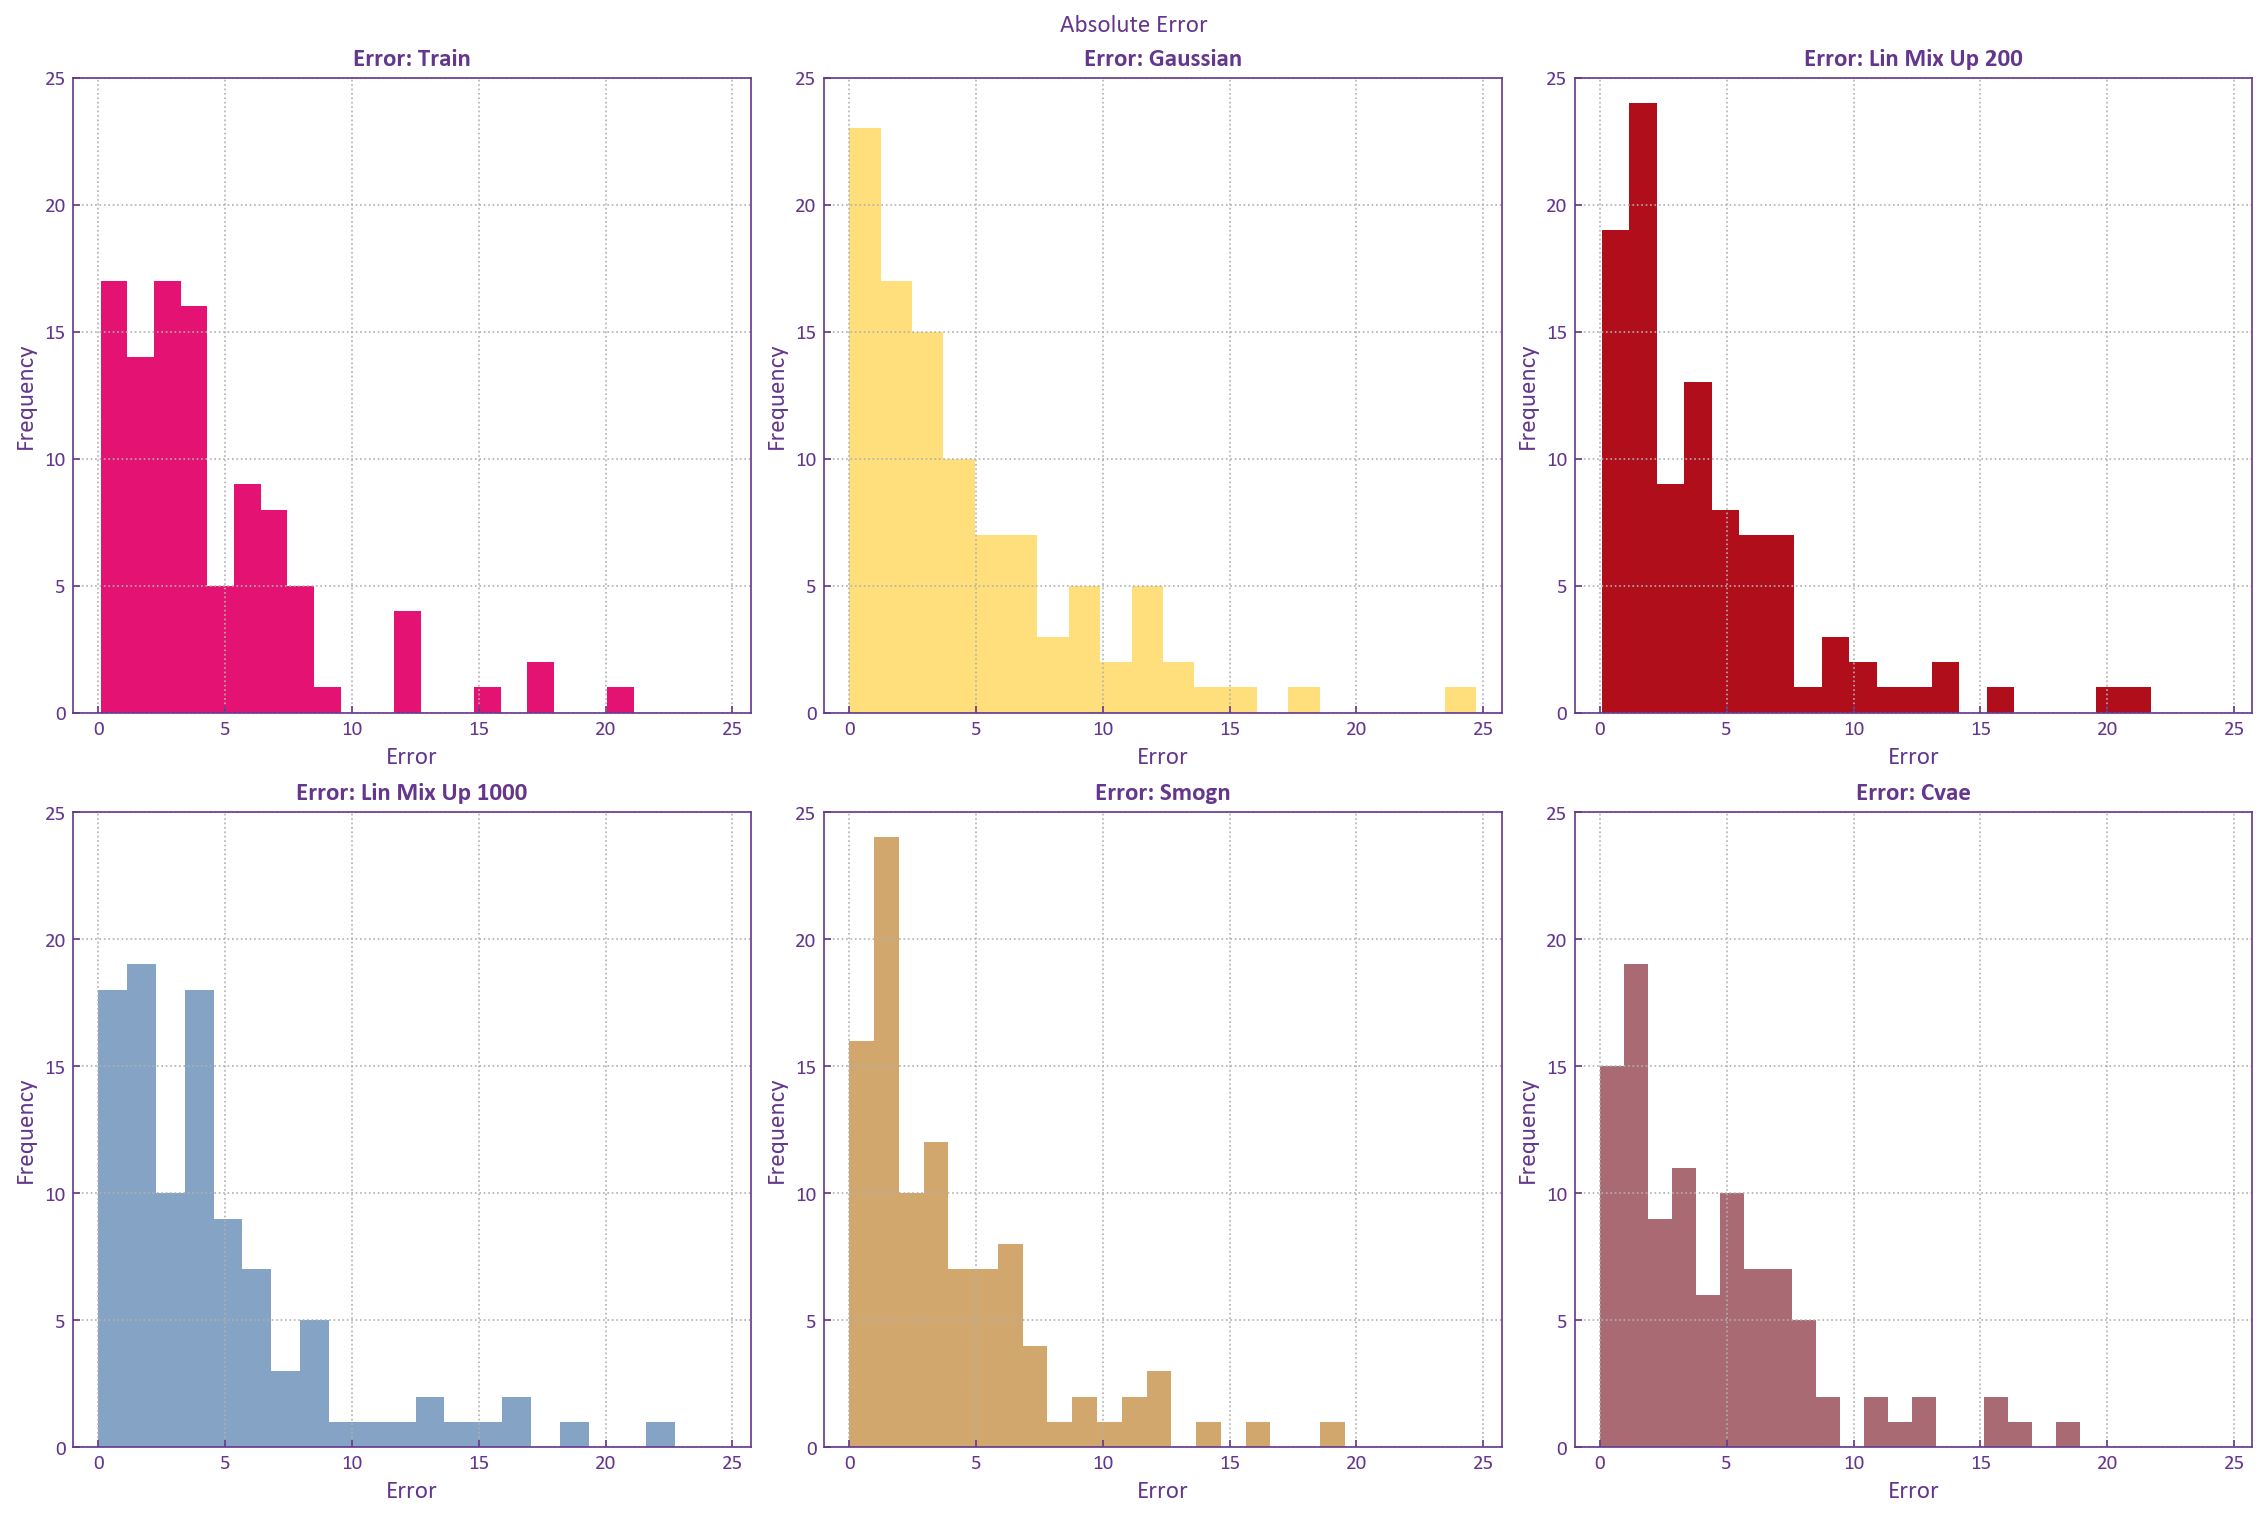

In [5]:
# Number of models
model_names = list(models.keys())
priority_list = ["Train", "Gaussian", "Lin Mix Up 200", "Lin Mix Up 1000", "Smogn", "Cvae"]
model_names = sorted(
    model_names,
    key=lambda x: priority_list.index(x) if x in priority_list else len(priority_list)
)

num_models = len(model_names)

#
# Find the Max-Y and the X-Axis Range to make the plots comparable
#
all_errors = np.concatenate([models[name]['error'] for name in model_names])
x_min, x_max = all_errors.min(), all_errors.max()
bins = 20
max_count = 0
for name in model_names:
    counts, _ = np.histogram(models[name]['error'], bins=bins, range=(x_min, x_max))
    if counts.max() > max_count:
        max_count = counts.max()

# Determine subplot layout
if num_models >= 4:
    cols = 3
    rows = (num_models + 1) // 3  # wrap to multiple rows
else:
    rows = 1
    cols = num_models

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), constrained_layout=True)
axes = np.array(axes).reshape(-1)  # flatten for consistent indexing

fig.suptitle('Absolute Error')

if num_models == 1:
    axes = [axes]  # ensure axes is always iterable

for i, name in enumerate(model_names):
    ax = axes[i]
    errors = models[name]['error']
    ax.hist(errors, bins=bins, color=models[name]['color'])
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(0, max_count + 1)  # add a little padding on top
    ax.set_title(f"Error: {name}")
    ax.set_xlabel("Error")
    ax.set_ylabel("Frequency")
    ax.grid(True)

plt.savefig(f"{FIG_PATH}{fig._suptitle.get_text()}")
plt.show()

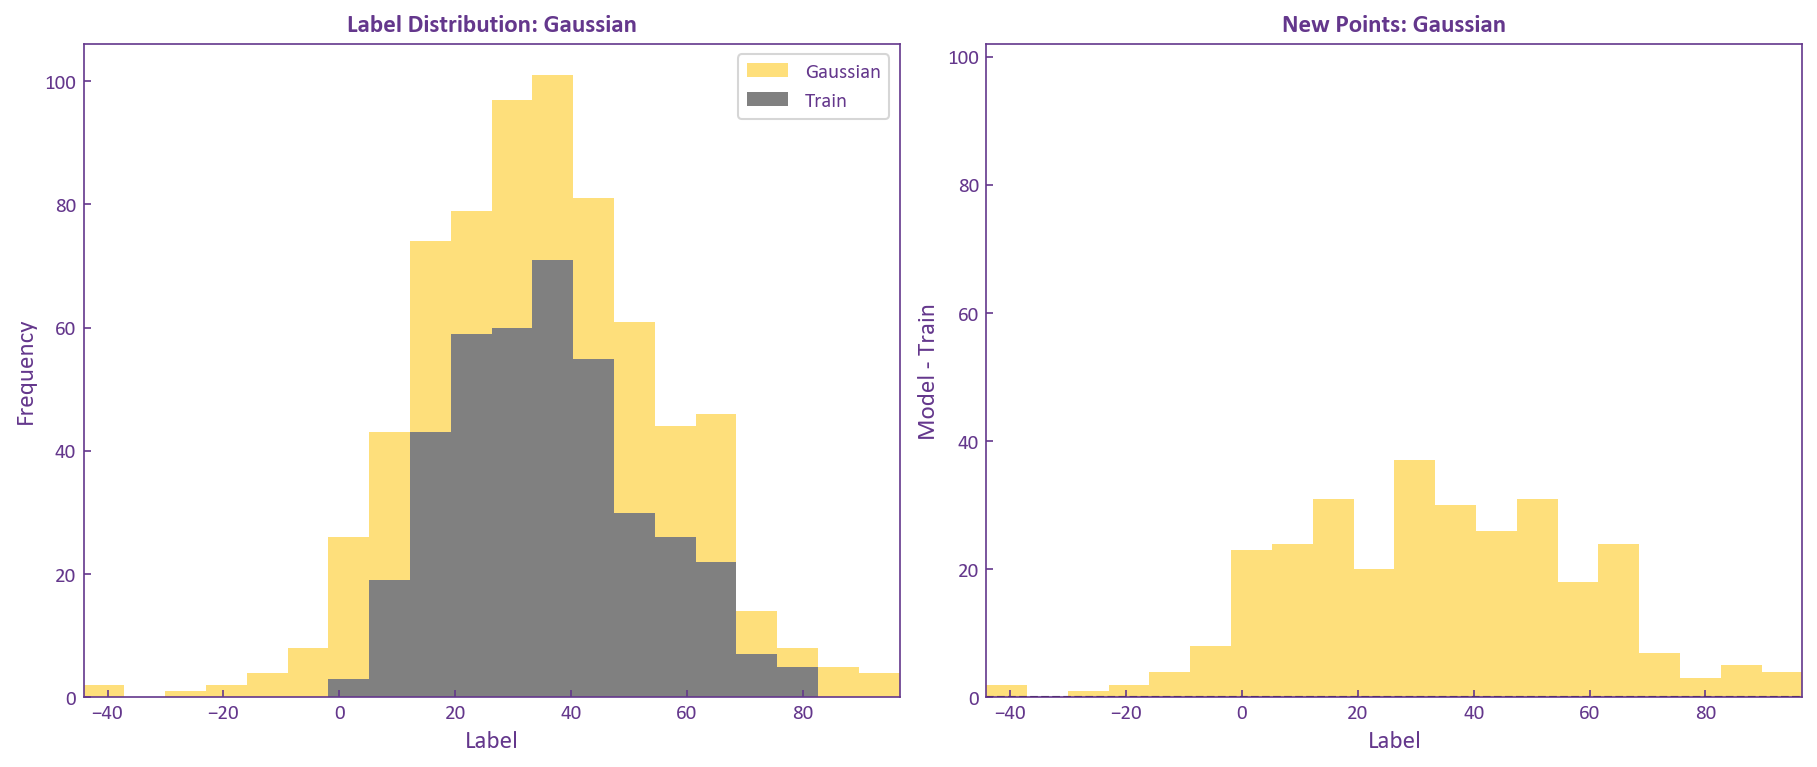

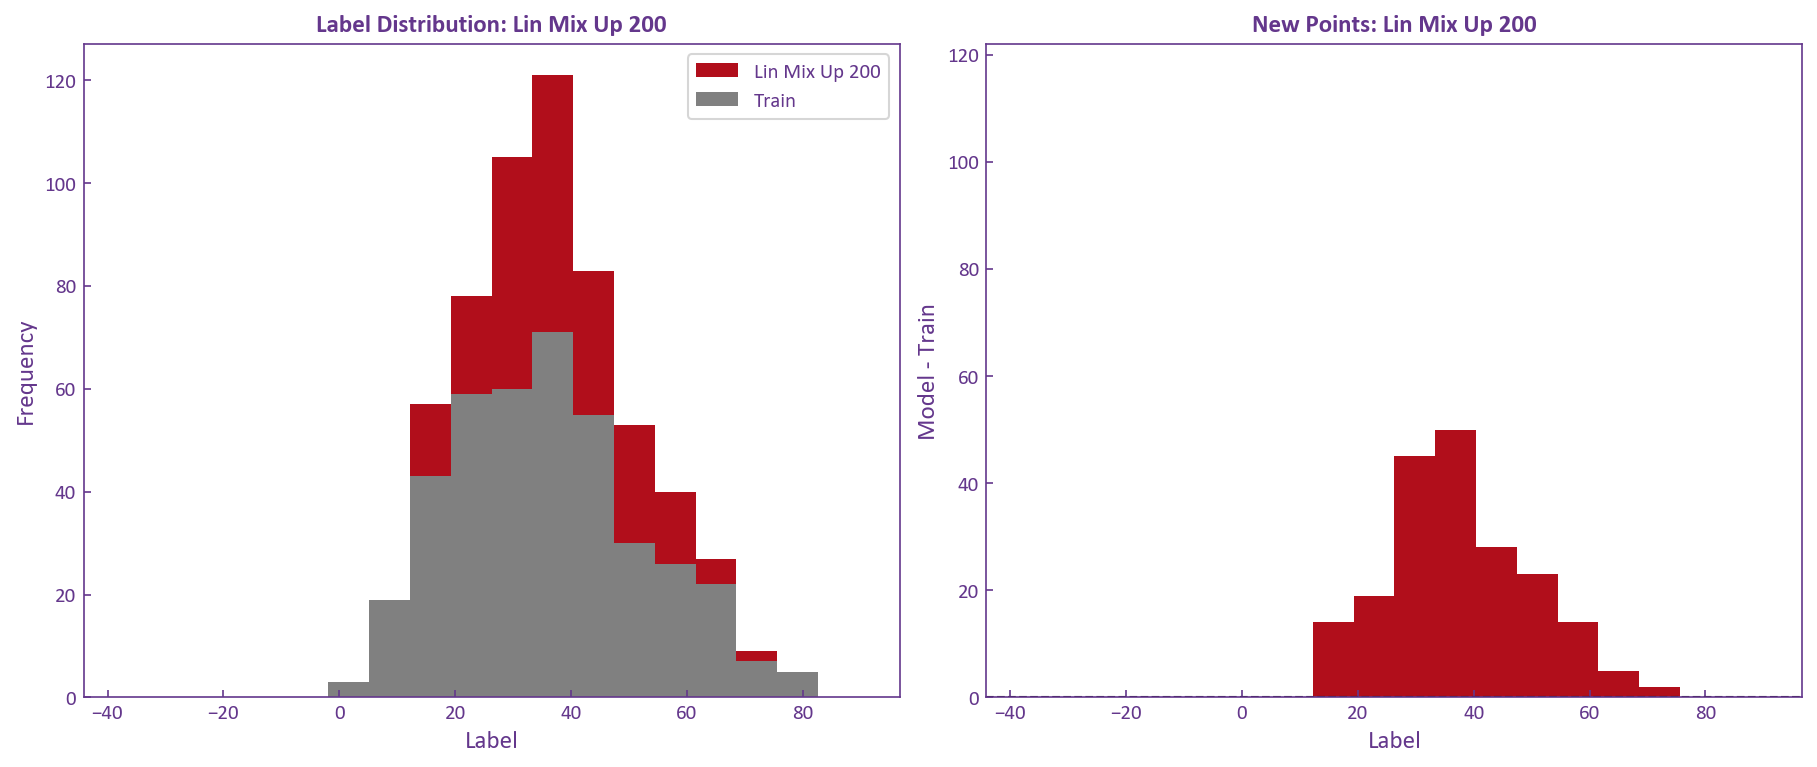

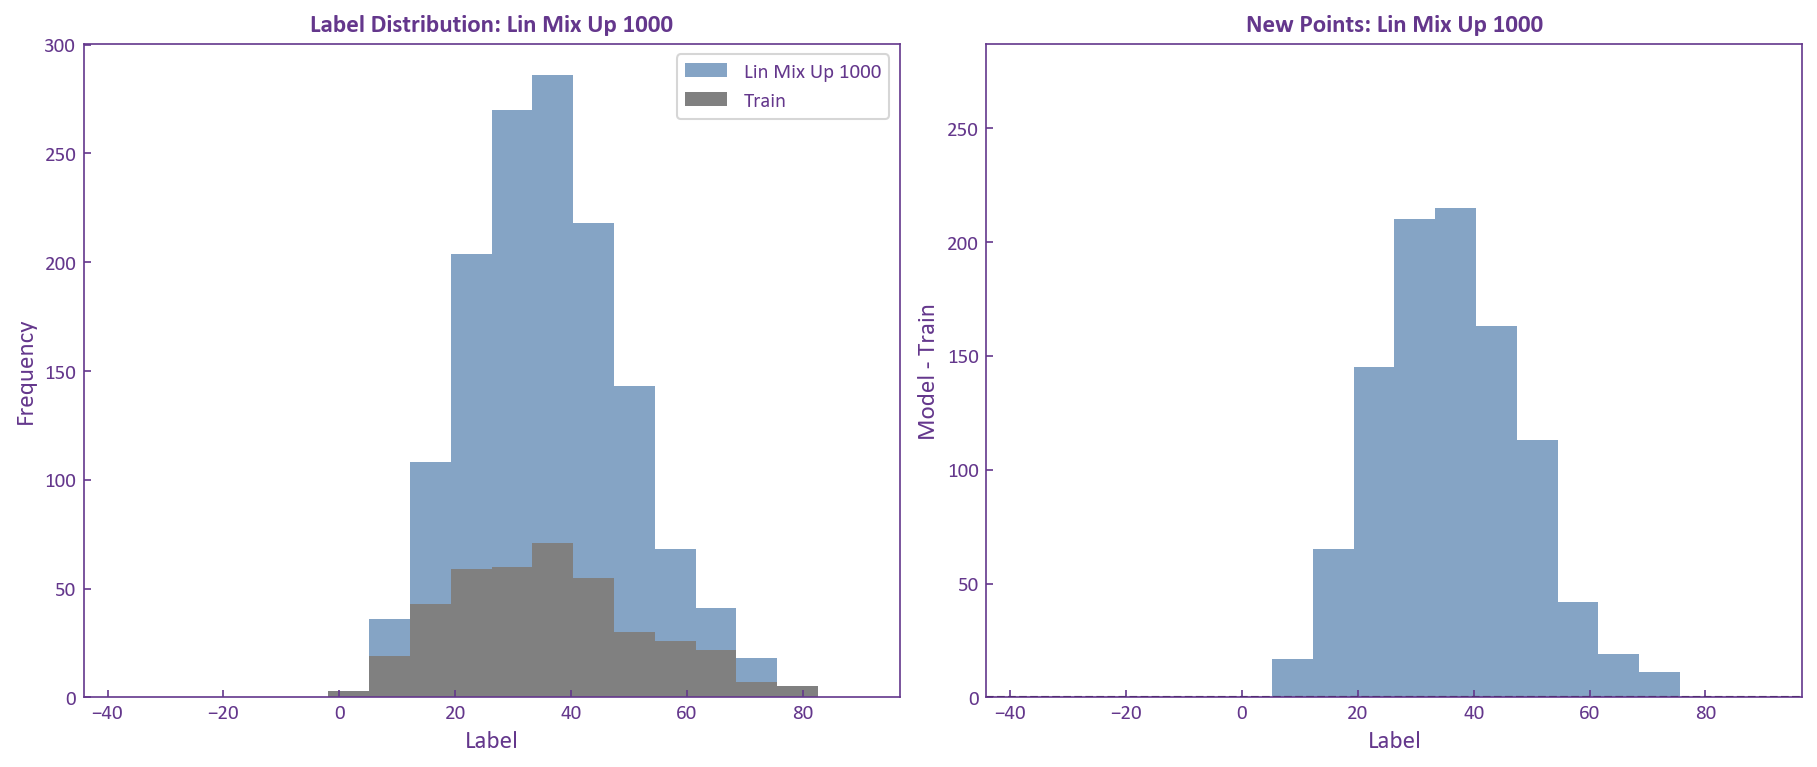

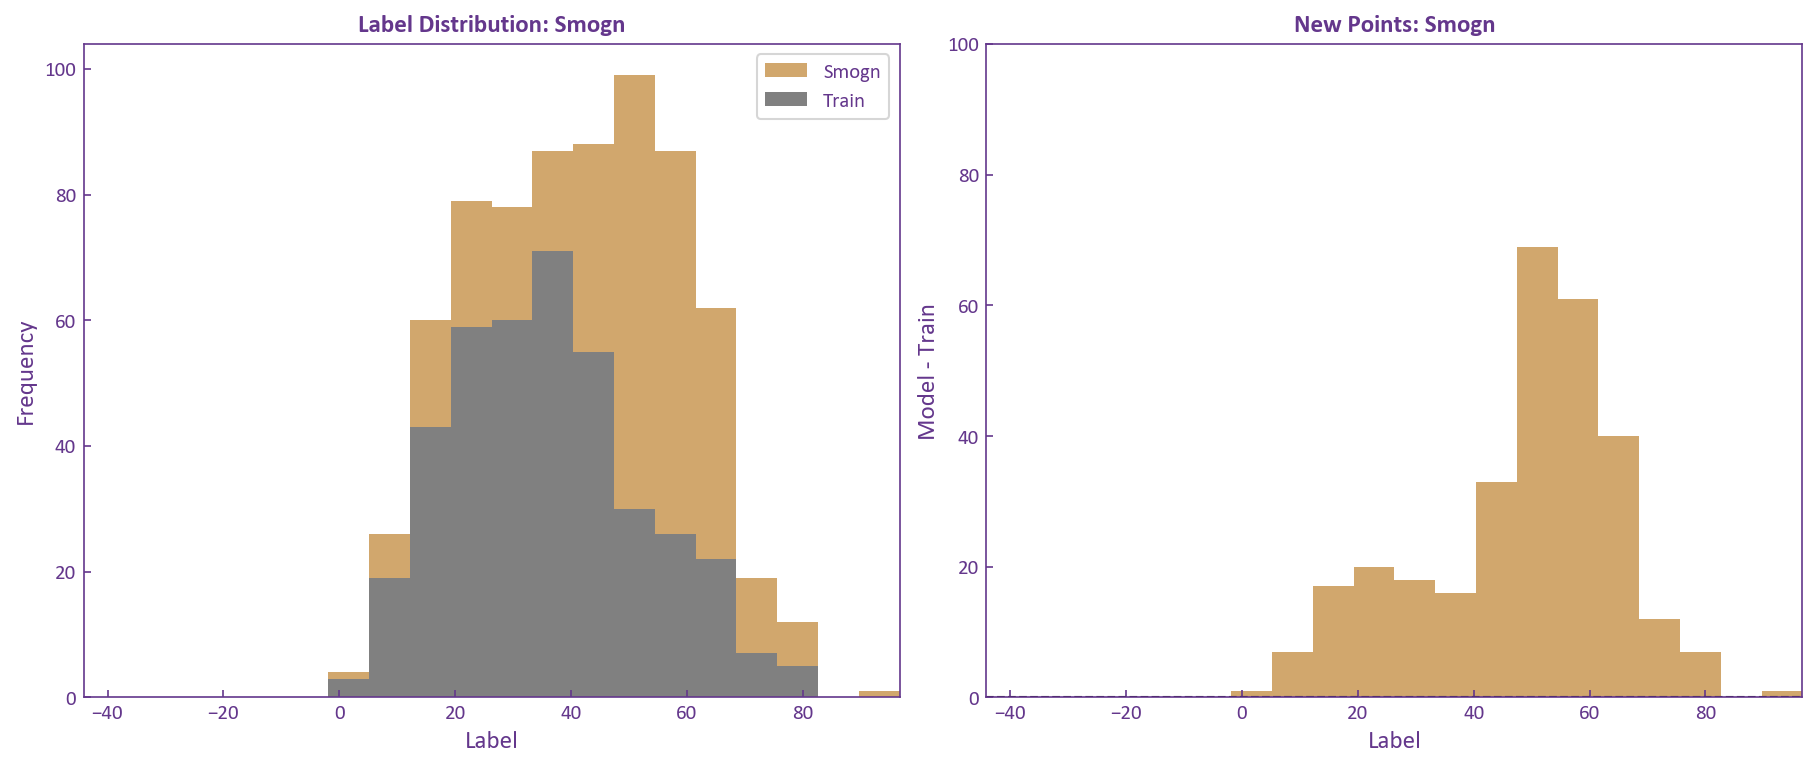

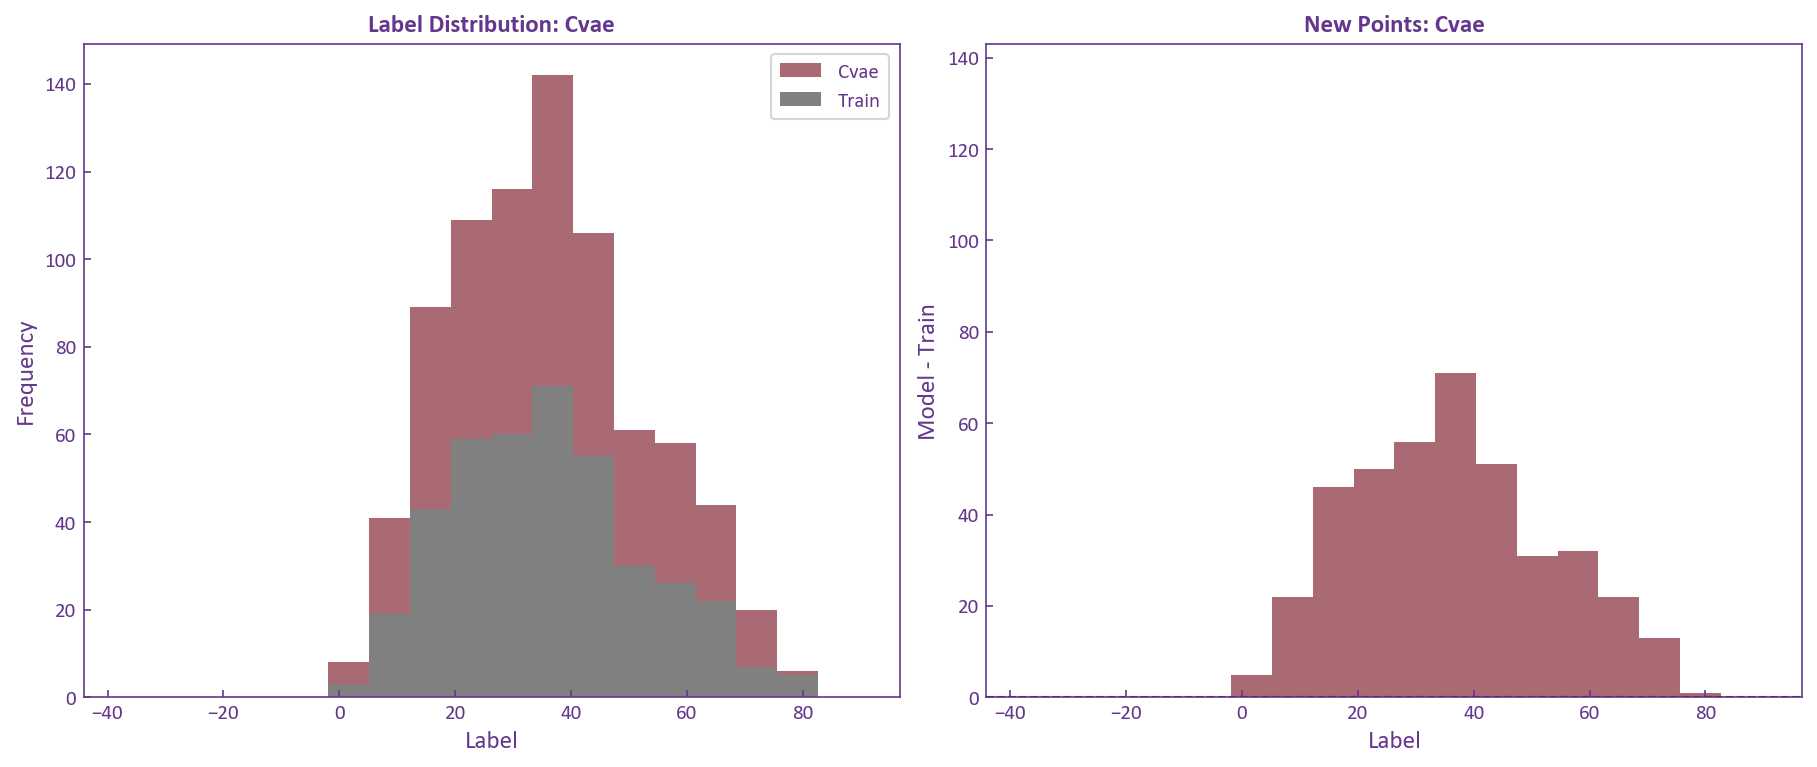

In [27]:
# Sort model names
model_names = list(models.keys())
priority_list = ["Train", "Gaussian", "Lin Mix Up 200", "Lin Mix Up 1000", "Smogn", "Cvae"]
model_names = sorted(
    model_names,
    key=lambda x: priority_list.index(x) if x in priority_list else len(priority_list)
)

# Define global range for consistency
all_labels = np.concatenate([models[name]['label'] for name in model_names])
x_min, x_max = all_labels.min(), all_labels.max()
bins = 20

# Get Train labels and histogram
train_labels = models["Train"]['label']
train_hist, bin_edges = np.histogram(train_labels, bins=bins, range=(x_min, x_max))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

for name in model_names:
    if name == "Train":
        continue

    model_labels = models[name]['label']
    model_color = models[name].get('color', 'blue')

    # Compute model histogram
    model_hist, _ = np.histogram(model_labels, bins=bins, range=(x_min, x_max))
    diff_hist = model_hist - train_hist

    # 
    y_max = max(model_hist.max(), train_hist.max())

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    # --- Plot 1: Label Distribution with Train Overlay ---
    axes[0].hist(model_labels, bins=bins, range=(x_min, x_max), alpha=1.0, color=model_color, label=name)
    axes[0].hist(train_labels, bins=bins, range=(x_min, x_max), alpha=1.0, color='gray', label='Train')
    axes[0].set_xlim(x_min, x_max)
    axes[0].set_title(f"Label Distribution: {name}")
    axes[0].set_xlabel("Label")
    axes[0].set_ylabel("Frequency")
    axes[0].legend()
    axes[0].grid(False)

    # --- Plot 2: Difference from Train ---
    axes[1].bar(bin_centers, diff_hist, width=(bin_edges[1] - bin_edges[0]), color=model_color)
    axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1].set_xlim(x_min, x_max)
    axes[1].set_ylim(0, y_max + 1)  # match scaling
    axes[1].set_title(f"New Points: {name}")
    axes[1].set_xlabel("Label")
    axes[1].set_ylabel("Model - Train")
    axes[1].grid(False)

    # Save combined figure
    filename = f"{FIG_PATH}Label Distribution With Diff {name.replace(' ', '_')}.png"
    plt.savefig(filename)
    plt.show()
    plt.close()


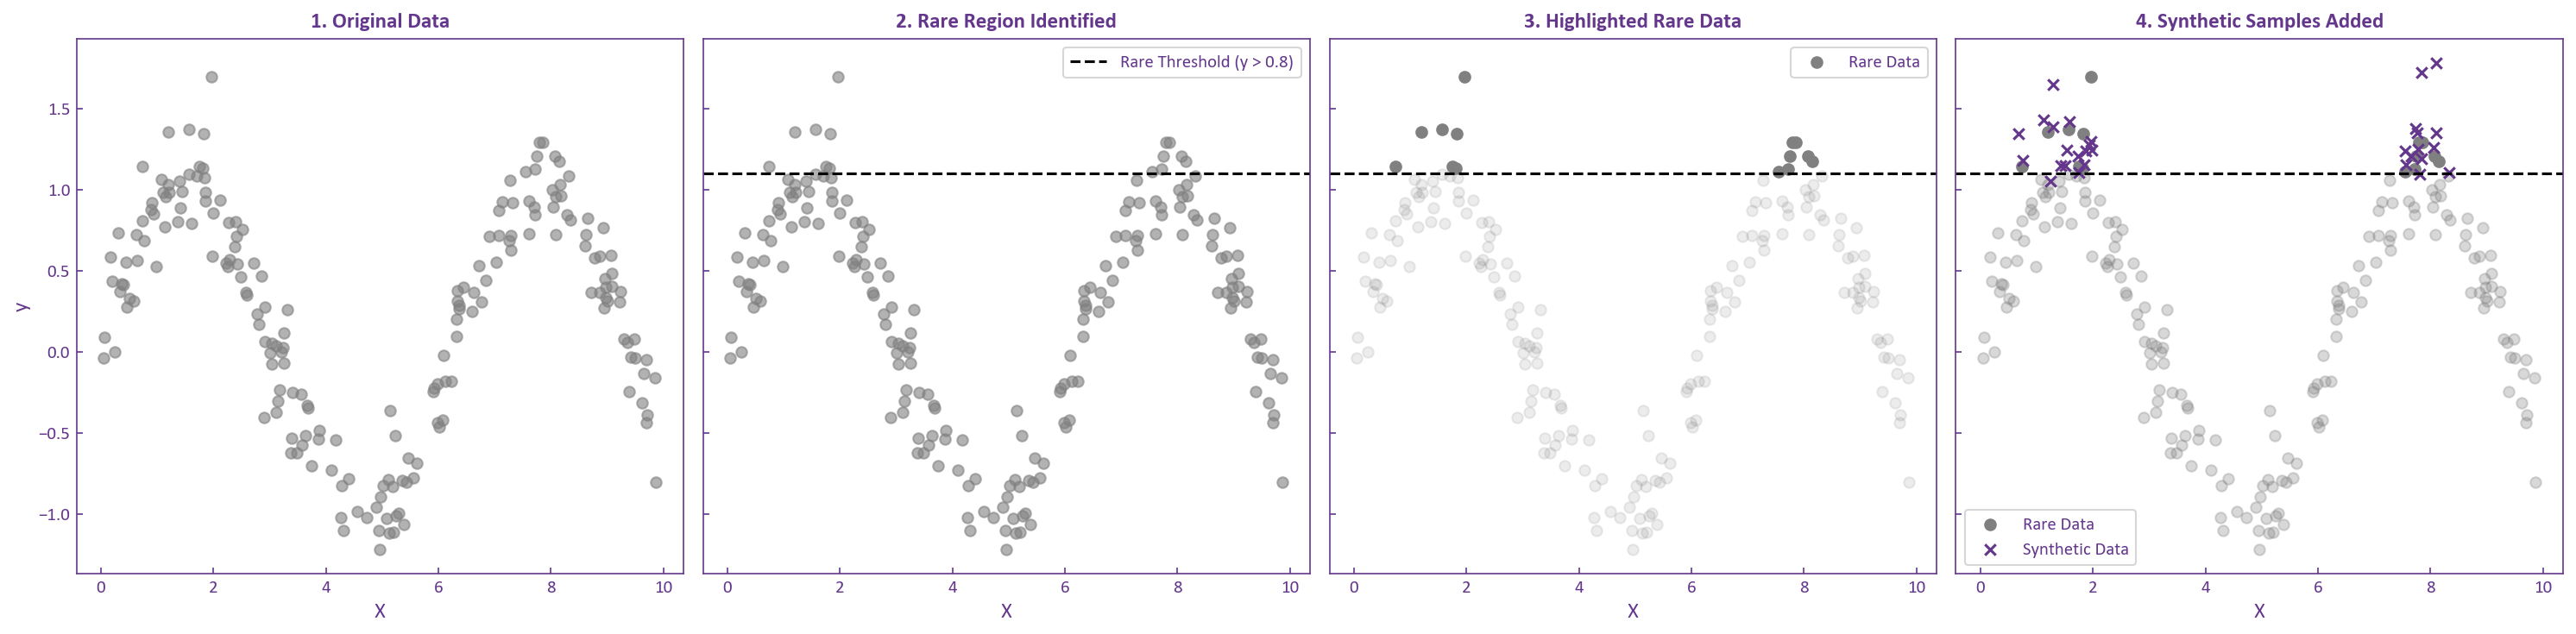

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Generate synthetic tabular data
np.random.seed(42)
n_points = 200
X = np.random.uniform(0, 10, size=n_points)
y = np.sin(X) + np.random.normal(0, 0.2, size=n_points)

# Define rare region: target values above 0.8
rare_threshold = 1.1
rare_indices = np.where(y > rare_threshold)[0]

# Step 2: Generate synthetic samples for rare region
n_synthetic = 30
rare_X = X[rare_indices]
rare_y = y[rare_indices]

# Randomly sample rare points and add Gaussian noise
synthetic_X = np.random.choice(rare_X, size=n_synthetic, replace=True) + np.random.normal(0, 0.1, size=n_synthetic)
synthetic_y = np.random.choice(rare_y, size=n_synthetic, replace=True) + np.random.normal(0, 0.05, size=n_synthetic)

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# Plot 1: Original data
axes[0].scatter(X, y, color='gray', alpha=0.6)
axes[0].set_title("1. Original Data")
axes[0].set_xlabel("X")
axes[0].set_ylabel("y")

# Plot 2: Rare region annotation
axes[1].scatter(X, y, color='gray', alpha=0.6)
axes[1].axhline(rare_threshold, color='black', linestyle='--', label='Rare Threshold (y > 0.8)')
axes[1].legend()
axes[1].set_title("2. Rare Region Identified")
axes[1].set_xlabel("X")

# Plot 3: Highlighted rare data
axes[2].scatter(X, y, color='gray', alpha=0.15)
axes[2].scatter(X[rare_indices], y[rare_indices], color='gray', label='Rare Data')
axes[2].axhline(rare_threshold, color='black', linestyle='--')
axes[2].legend()
axes[2].set_title("3. Highlighted Rare Data")
axes[2].set_xlabel("X")

# Plot 4: Synthetic points added
axes[3].scatter(X, y, color='gray', alpha=0.3)
axes[3].scatter(X[rare_indices], y[rare_indices], color='gray', label='Rare Data')
axes[3].scatter(synthetic_X, synthetic_y, color="#64378CFF", marker='x', label='Synthetic Data')
axes[3].axhline(rare_threshold, color='black', linestyle='--')
axes[3].legend()
axes[3].set_title("4. Synthetic Samples Added")
axes[3].set_xlabel("X")

plt.tight_layout()
plt.savefig(f"{FIG_PATH}Smogn Step by Step.png")
plt.show()

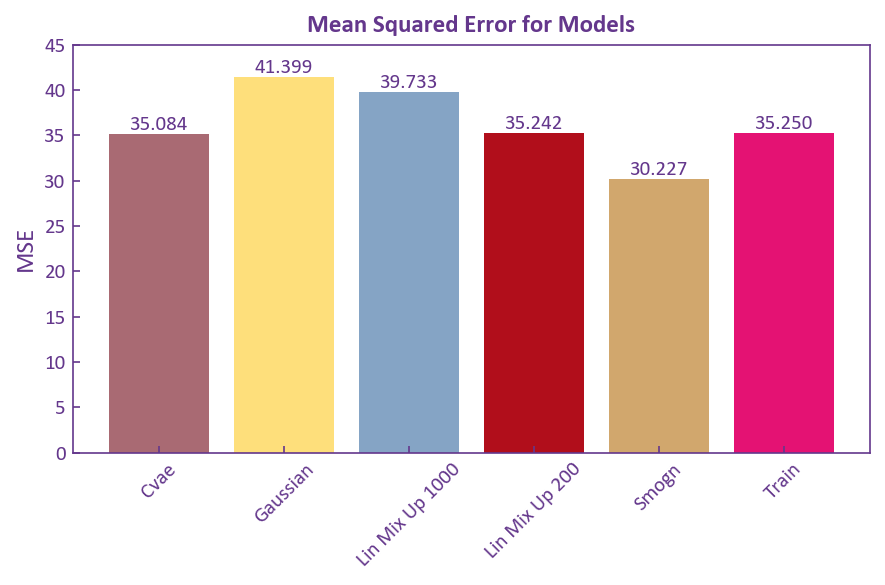

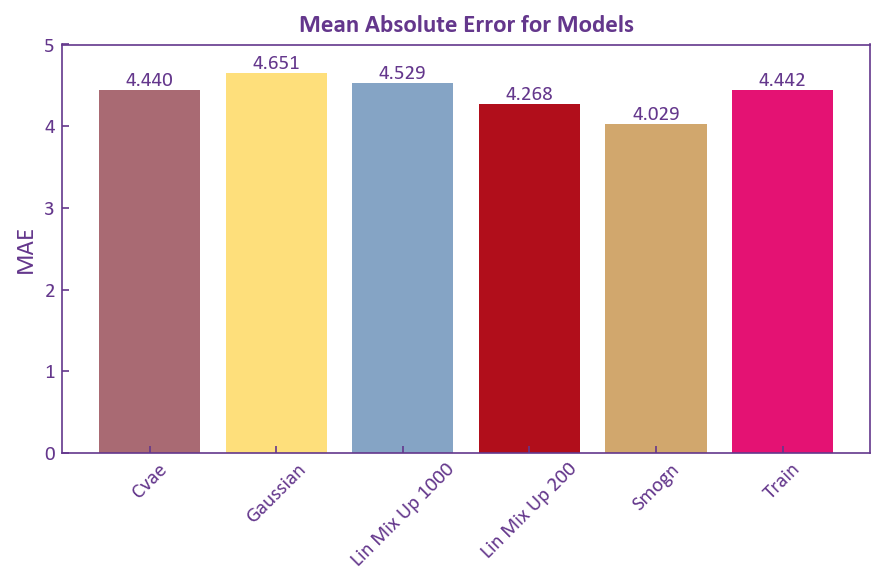

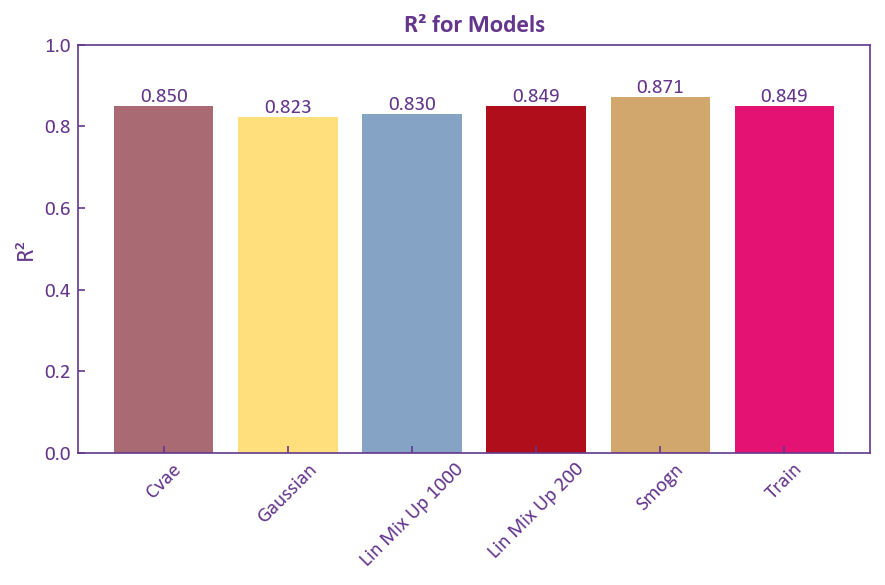

In [6]:
single_metrics = {
    "mse": {'fn': mean_squared_error, 'name': 'Mean Squared Error', 'short': 'MSE', 'y_lim': (0, 45)},
    "mae": {'fn': mean_absolute_error, 'name': 'Mean Absolute Error', 'short': 'MAE', 'y_lim': (0, 5)},
    "r2": {'fn': r2_score, 'name': 'R²', 'short': 'R²', 'y_lim': (0, 1)}
    }

for metric, values in single_metrics.items():
    model_names = []
    metrics = []
    colors = []
    for key, model in models.items():
        y_pred = model['y_pred']
        model_names.append(model['name'])
        metrics.append(values['fn'](y_test, y_pred))
        colors.append(model['color'])

    plt.figure(figsize=(6, 4))
    plt.bar(model_names, metrics, color=colors)
    for i, v in enumerate(metrics):
        plt.text(i, v, f"{v:.3f}", ha='center', va='bottom')
    plt.title(f'{values['name']} for Models')
    plt.ylabel(values['short'])
    plt.ylim(values['y_lim'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{FIG_PATH}{plt.gca().get_title()}")
    plt.show()


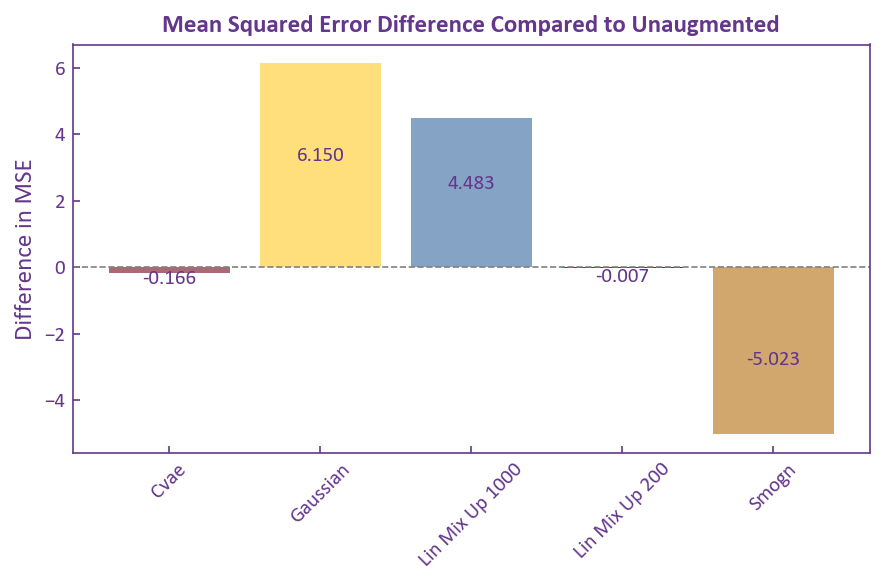

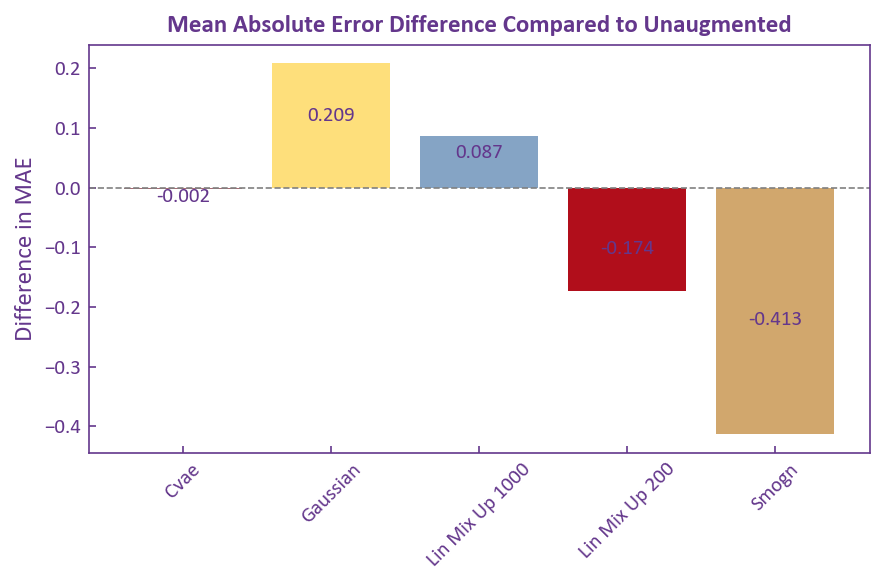

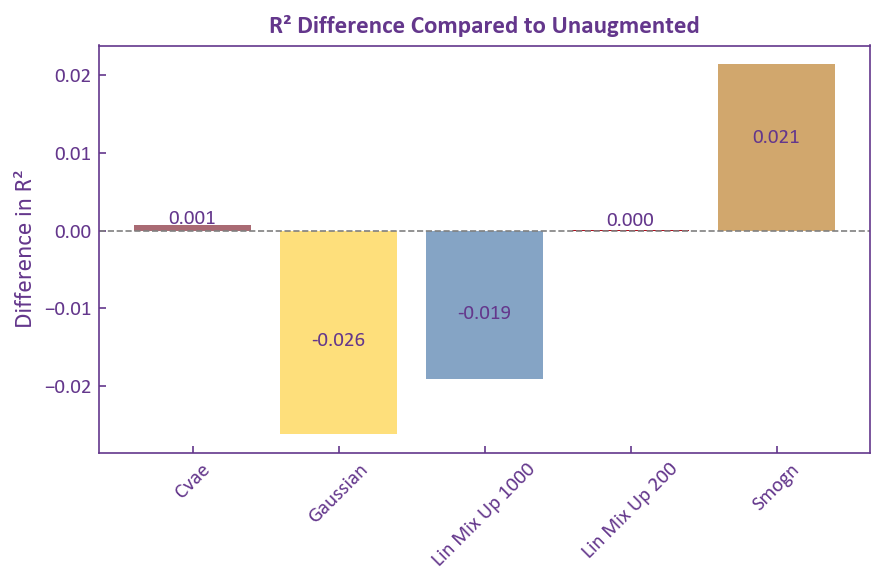

In [7]:
# Set the baseline model name here:
baseline_model_name = 'Train'

assert baseline_model_name in models.keys()

for metric, values in single_metrics.items():
    model_names = []
    metrics = []
    colors = []

    # Calculate each model's metric
    for key, model in models.items():
        if model['name'] == baseline_model_name:
            y_pred = model['y_pred']
            baseline_value = values['fn'](y_test, y_pred)
            continue

        y_pred = model['y_pred']
        model_names.append(model['name'])
        metrics.append(values['fn'](y_test, y_pred))
        colors.append(model['color'])

    # Subtract baseline metric from all
    metrics_diff = [m - baseline_value for m in metrics]
    plt.figure(figsize=(6, 4))
    bars = plt.bar(model_names, metrics_diff, color=colors)
    
    # 
    for i, v in enumerate(metrics_diff):
        plt.text(i, v / 2, f"{v:.3f}", ha='center', va='bottom' if v >= 0 else 'top')
    
    plt.title(f"{values['name']} Difference Compared to Unaugmented")
    plt.ylabel(f"Difference in {values['short']}")
    plt.xticks(rotation=45)
    plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    plt.tight_layout()
    plt.savefig(f"{FIG_PATH}{plt.gca().get_title()}")
    plt.show()
